In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('marsWeather.csv')

In [3]:
df.head()

,index,id,terrestrial_date,sol,ls,season,min_temp,max_temp,pressure,wind_speed,atmo_opacity
0,0,435,02-01-2014,501,70,Month 3,-86.0,-28.0,898.0,NaN,Sunny
1,2,437,03-01-2014,502,71,Month 3,-87.0,-30.0,898.0,NaN,Sunny
2,41,483,04-01-2014,503,71,Month 3,-86.0,-28.0,897.0,NaN,Sunny
3,1,436,05-01-2014,504,72,Month 3,-85.0,-29.0,895.0,NaN,Sunny
4,3,438,06-01-2014,505,72,Month 3,-85.0,-29.0,895.0,NaN,Sunny


In [4]:
df=df.drop(columns=['wind_speed','atmo_opacity','index'])

In [5]:
df=df[df['pressure'].notna()]

In [6]:
df.isna().sum()

id                  0
terrestrial_date    0
sol                 0
ls                  0
season              0
min_temp            1
max_temp            1
pressure            0
dtype: int64

In [7]:
df=df[df['min_temp'].notna()]

In [8]:
df.isna().sum()

id                  0
terrestrial_date    0
sol                 0
ls                  0
season              0
min_temp            0
max_temp            0
pressure            0
dtype: int64

In [9]:
df['terrestrial_date'] = df['terrestrial_date'].astype(str).str.strip()  # remove spaces
df['terrestrial_date'] = df['terrestrial_date'].str.replace(r'[^0-9\-]', '', regex=True)  # remove bad chars

In [10]:
df

,id,terrestrial_date,sol,ls,season,min_temp,max_temp,pressure
0,435,02-01-2014,501,70,Month 3,-86.0,-28.0,898.0
1,437,03-01-2014,502,71,Month 3,-87.0,-30.0,898.0
2,483,04-01-2014,503,71,Month 3,-86.0,-28.0,897.0
3,436,05-01-2014,504,72,Month 3,-85.0,-29.0,895.0
4,438,06-01-2014,505,72,Month 3,-85.0,-29.0,895.0
...,...,...,...,...,...,...,...,...
3031,3479,21-11-2022,3659,341,Month 12,-72.0,-12.0,798.0
3032,3477,22-11-2022,3660,342,Month 12,-72.0,-10.0,798.0
3033,3478,23-11-2022,3661,342,Month 12,-73.0,-8.0,797.0
3034,3474,24-11-2022,3662,343,Month 12,-72.0,-9.0,800.0


In [11]:
df['terrestrial_date'].dtype

dtype('O')

In [12]:
df['terrestrial_date']=pd.to_datetime(df['terrestrial_date'],format='%d-%m-%Y')

In [13]:
df

,id,terrestrial_date,sol,ls,season,min_temp,max_temp,pressure
0,435,2014-01-02,501,70,Month 3,-86.0,-28.0,898.0
1,437,2014-01-03,502,71,Month 3,-87.0,-30.0,898.0
2,483,2014-01-04,503,71,Month 3,-86.0,-28.0,897.0
3,436,2014-01-05,504,72,Month 3,-85.0,-29.0,895.0
4,438,2014-01-06,505,72,Month 3,-85.0,-29.0,895.0
...,...,...,...,...,...,...,...,...
3031,3479,2022-11-21,3659,341,Month 12,-72.0,-12.0,798.0
3032,3477,2022-11-22,3660,342,Month 12,-72.0,-10.0,798.0
3033,3478,2022-11-23,3661,342,Month 12,-73.0,-8.0,797.0
3034,3474,2022-11-24,3662,343,Month 12,-72.0,-9.0,800.0


In [14]:
df['terrestrial_date'].dtype

dtype('<M8[ns]')

In [15]:
print(df['terrestrial_date'].head())
#print(df['terrestrial_date'].apply(type).unique())


0   2014-01-02
1   2014-01-03
2   2014-01-04
3   2014-01-05
4   2014-01-06
Name: terrestrial_date, dtype: datetime64[ns]


In [16]:
df

,id,terrestrial_date,sol,ls,season,min_temp,max_temp,pressure
0,435,2014-01-02,501,70,Month 3,-86.0,-28.0,898.0
1,437,2014-01-03,502,71,Month 3,-87.0,-30.0,898.0
2,483,2014-01-04,503,71,Month 3,-86.0,-28.0,897.0
3,436,2014-01-05,504,72,Month 3,-85.0,-29.0,895.0
4,438,2014-01-06,505,72,Month 3,-85.0,-29.0,895.0
...,...,...,...,...,...,...,...,...
3031,3479,2022-11-21,3659,341,Month 12,-72.0,-12.0,798.0
3032,3477,2022-11-22,3660,342,Month 12,-72.0,-10.0,798.0
3033,3478,2022-11-23,3661,342,Month 12,-73.0,-8.0,797.0
3034,3474,2022-11-24,3662,343,Month 12,-72.0,-9.0,800.0


In [17]:
df['season'] = df['season'].apply(lambda x: x.split()[1])

In [18]:
df['season']=pd.to_numeric(df['season'],errors='coerce')

In [19]:
path='cleaned_marsWeather.csv'
df.to_csv(path,index=False)
print(f"\nCleaned data successfully exported to {path}")


Cleaned data successfully exported to cleaned_marsWeather.csv


In [20]:
pd.read_csv('cleaned_marsWeather.csv')

,id,terrestrial_date,sol,ls,season,min_temp,max_temp,pressure
0,435,2014-01-02,501,70,3,-86.0,-28.0,898.0
1,437,2014-01-03,502,71,3,-87.0,-30.0,898.0
2,483,2014-01-04,503,71,3,-86.0,-28.0,897.0
3,436,2014-01-05,504,72,3,-85.0,-29.0,895.0
4,438,2014-01-06,505,72,3,-85.0,-29.0,895.0
...,...,...,...,...,...,...,...,...
3024,3479,2022-11-21,3659,341,12,-72.0,-12.0,798.0
3025,3477,2022-11-22,3660,342,12,-72.0,-10.0,798.0
3026,3478,2022-11-23,3661,342,12,-73.0,-8.0,797.0
3027,3474,2022-11-24,3662,343,12,-72.0,-9.0,800.0


### Min Temp

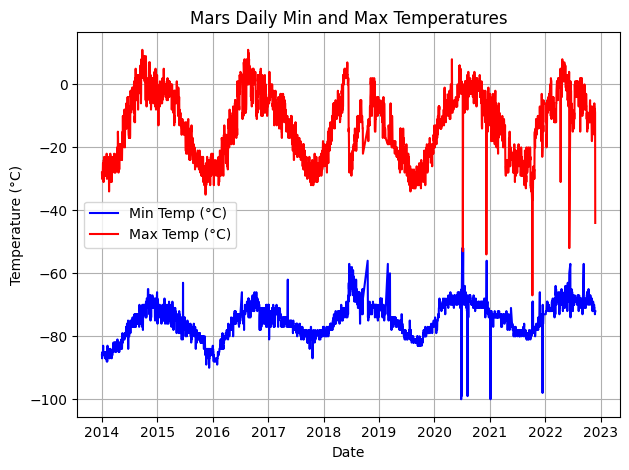

In [21]:
plt.plot(df['terrestrial_date'], df['min_temp'], label='Min Temp (°C)', color='blue')
plt.plot(df['terrestrial_date'], df['max_temp'], label='Max Temp (°C)', color='red')
plt.title('Mars Daily Min and Max Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

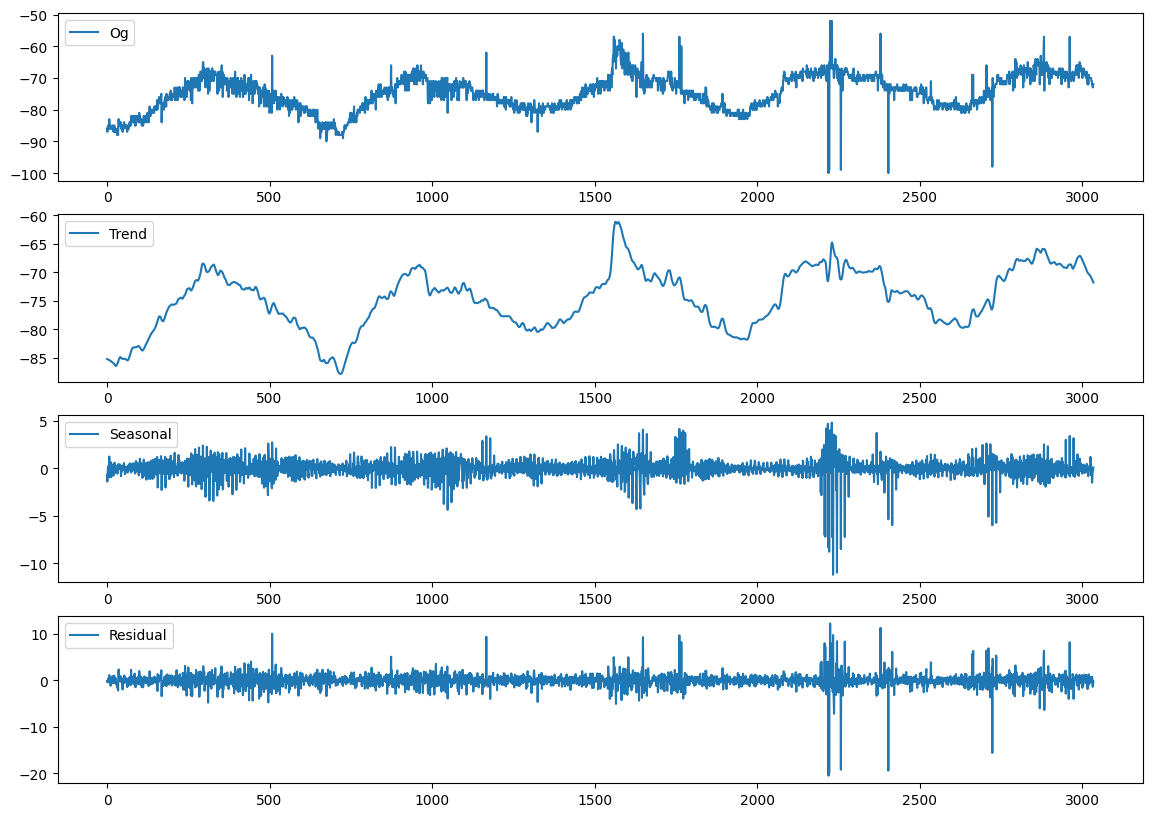

In [22]:
stl = STL(df['min_temp'], period=12)  # e.g., 12 for monthly data
result=stl.fit()
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(result.observed,label='Og')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend,label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid,label='Residual')
plt.legend(loc='upper left')

In [23]:
result = adfuller(df['min_temp'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  #d=1

ADF Statistic: -2.691224649887089
p-value: 0.07556913678109513


In [24]:
print(adfuller(df['min_temp'].diff(365).dropna())) #D=1

(np.float64(-2.2253647450493577), np.float64(0.1971686366970974), 11, 2652, {'1%': np.float64(-3.4328181903683084), '5%': np.float64(-2.862630460868777), '10%': np.float64(-2.567350489894647)}, np.float64(13565.43376474261))


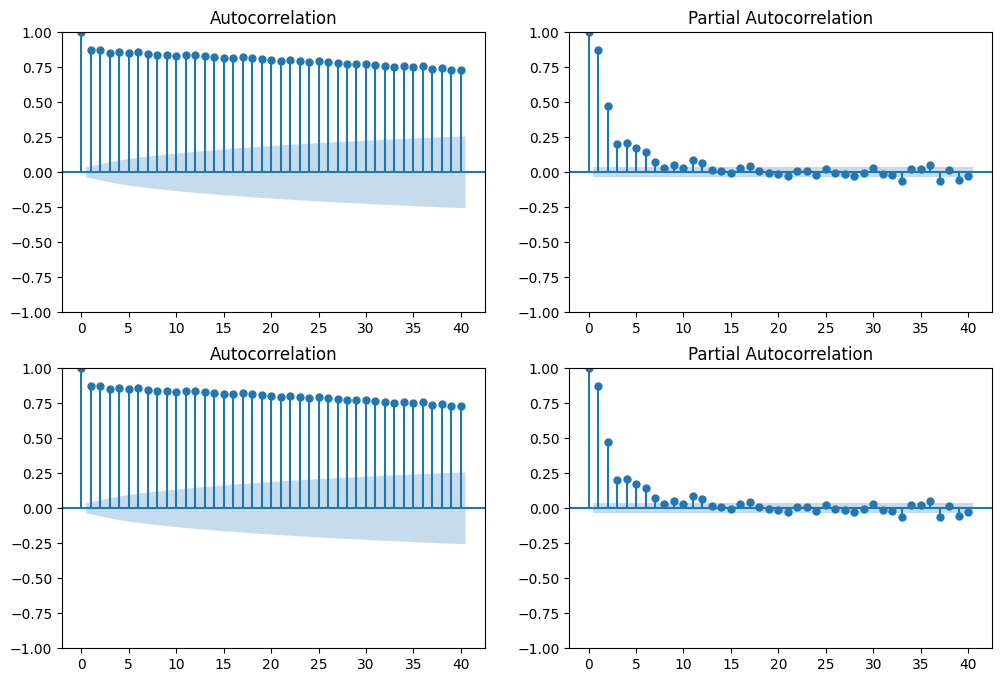

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
# Non-seasonal ACF and PACF
plot_acf(df['min_temp'].dropna(), lags=40, ax=axes[0,0])
plot_pacf(df['min_temp'].dropna(), lags=40, ax=axes[0,1])
# Seasonal ACF and PACF (lags at multiples of s)
plot_acf(df['min_temp'].dropna(), lags=40, ax=axes[1,0])
plot_pacf(df['min_temp'].dropna(), lags=40, ax=axes[1,1])

plt.show()

In [ ]:
#q=0 and p=2

In [26]:
model = SARIMAX(df['min_temp'], order=(2,0,1), seasonal_order=(1,1,1,12))
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           min_temp   No. Observations:                 3029
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -6682.497
Date:                            Sun, 15 Jun 2025   AIC                          13376.994
Time:                                    18:07:38   BIC                          13413.066
Sample:                                         0   HQIC                         13389.965
                                           - 3029                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0322      0.008    129.062      0.000       1.017       1.048
ar.L2         -0.0342      0.008   

In [27]:
residuals=results.resid

In [28]:
residuals=residuals.reindex(df['min_temp'].index)

In [29]:
residuals = residuals.fillna(0) 

In [30]:
model = SARIMAX(df['min_temp'], order=(2,0,1), seasonal_order=(1,1,1,12),exog=residuals)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           min_temp   No. Observations:                 3029
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -5048.867
Date:                            Sun, 15 Jun 2025   AIC                          10111.734
Time:                                    18:10:41   BIC                          10153.818
Sample:                                         0   HQIC                         10126.867
                                           - 3029                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.7021      0.002    317.842      0.000       0.698       0.706
ar.L1          0.7768      0.202   

In [39]:
future_exog=residuals.sample(100)
forecast = results.get_forecast(steps=100,exog=future_exog)  # forecast next 100 days

In [40]:
# Predicted mean (the forecast)
forecast_values = forecast.predicted_mean
#print(forecast_values)
# Confidence intervals
conf_int = forecast.conf_int()
print(pd.DataFrame({
    'Forecasted_values': forecast_values,
    'Conf_Int_lower': conf_int.iloc[:, 0],
    'Conf_Int_upper': conf_int.iloc[:, 1]
}))

      Forecasted_values  Conf_Int_lower  Conf_Int_upper
3029         -71.074607      -73.593016      -68.556198
3030         -70.667871      -74.131243      -67.204498
3031         -71.758044      -75.959578      -67.556510
3032         -71.411739      -76.225707      -66.597770
3033         -69.382039      -74.729178      -64.034899
...                 ...             ...             ...
3124         -72.067171      -93.074810      -51.059531
3125         -72.083905      -93.175582      -50.992229
3126         -69.812453      -90.985552      -48.639354
3127         -71.213400      -92.466144      -49.960657
3128         -70.509413      -91.839911      -49.178914

[100 rows x 3 columns]


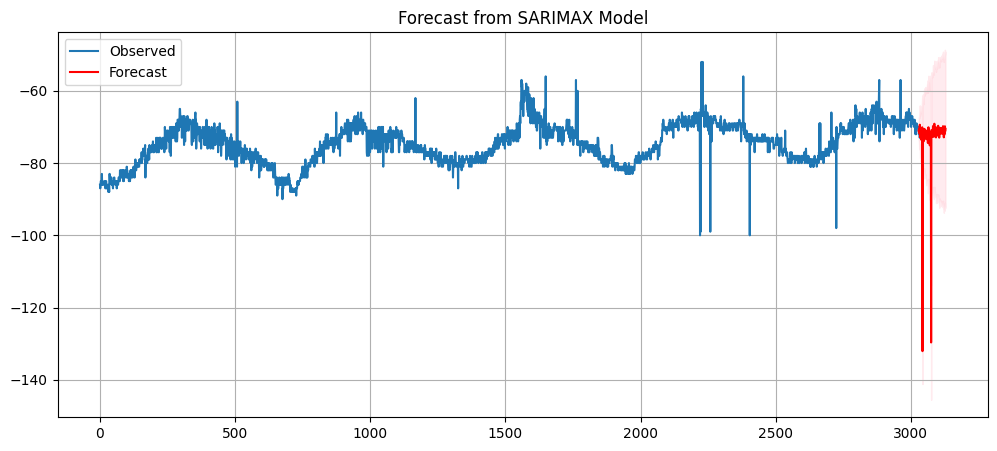

In [41]:
ax = df['min_temp'].plot(label='Observed', figsize=(12, 5))

# Plot forecast
forecast_values.plot(ax=ax, label='Forecast', color='red')

# Plot confidence intervals
ax.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1],
                color='pink', alpha=0.3)

plt.title("Forecast from SARIMAX Model")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
train = df['min_temp'][:-700]  # all but last n values
test = df['min_temp'][-700:]   # last n values

In [43]:
forecast = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [44]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²   : {r2:.3f}")

MAE: 0.38
RMSE: 0.72
MAPE: 0.52%
R²   : 0.976


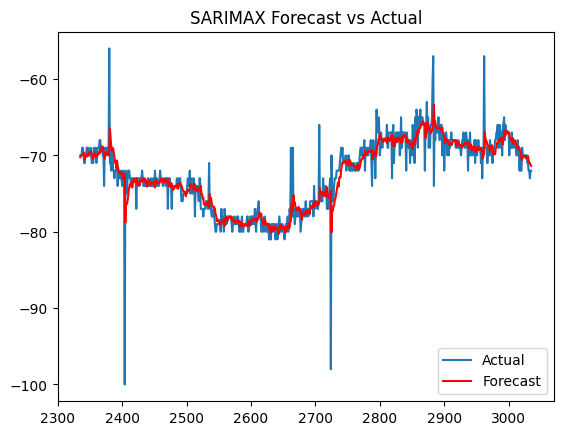

In [163]:
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()

### Max Temp

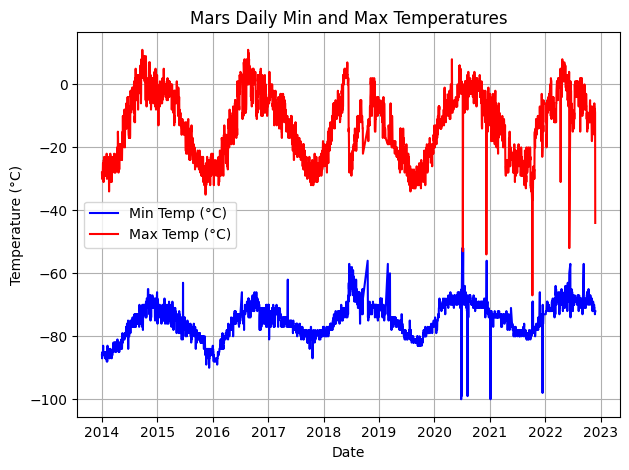

In [45]:
plt.plot(df['terrestrial_date'], df['min_temp'], label='Min Temp (°C)', color='blue')
plt.plot(df['terrestrial_date'], df['max_temp'], label='Max Temp (°C)', color='red')
plt.title('Mars Daily Min and Max Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

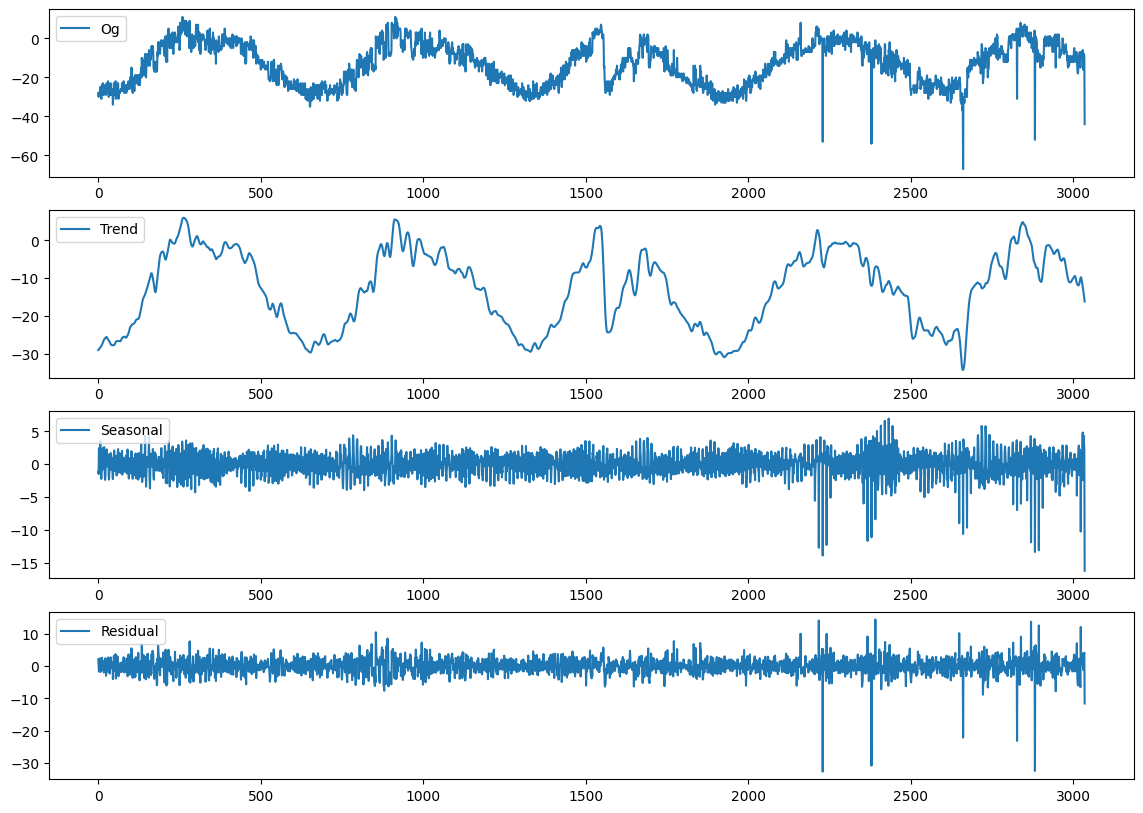

In [46]:
stl = STL(df['max_temp'], period=12)  # e.g., 12 for monthly data
result=stl.fit()
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(result.observed,label='Og')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend,label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid,label='Residual')
plt.legend(loc='upper left')

In [47]:
result = adfuller(df['max_temp'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  #d=0

ADF Statistic: -3.2675657978513226
p-value: 0.016392016033280214


In [48]:
print(adfuller(df['max_temp'].diff(365).dropna())) #D=1

(np.float64(-2.2901772528830917), np.float64(0.17515557663345044), 27, 2636, {'1%': np.float64(-3.4328331864239274), '5%': np.float64(-2.8626370834536976), '10%': np.float64(-2.56735401579277)}, np.float64(16293.920407705384))


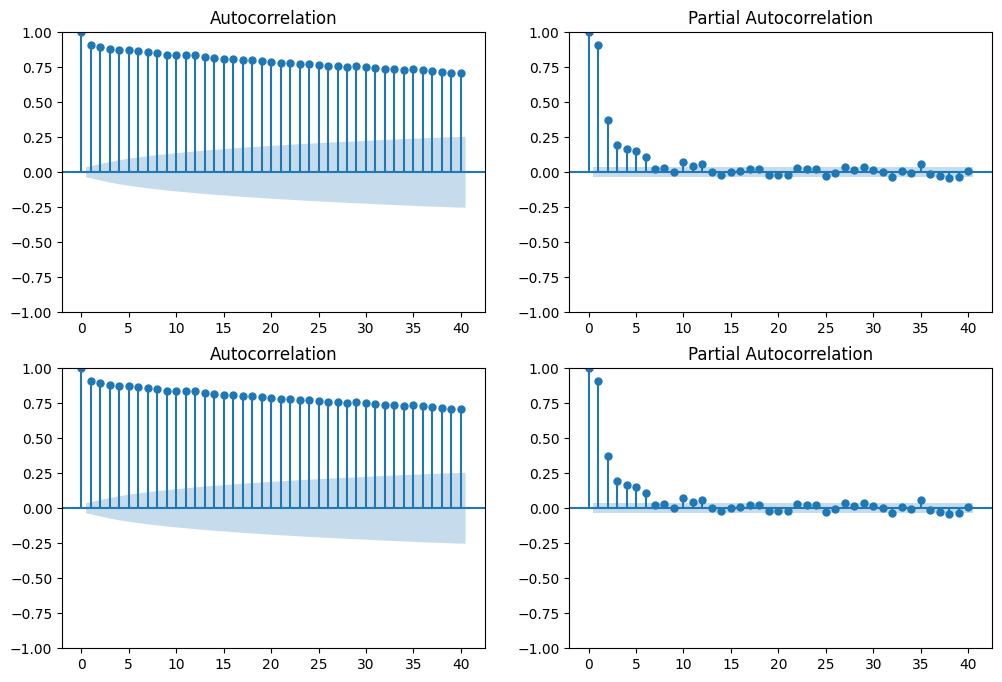

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
# Non-seasonal ACF and PACF
plot_acf(df['max_temp'].dropna(), lags=40, ax=axes[0,0])
plot_pacf(df['max_temp'].dropna(), lags=40, ax=axes[0,1])
# Seasonal ACF and PACF (lags at multiples of s)
plot_acf(df['max_temp'].dropna(), lags=40, ax=axes[1,0])
plot_pacf(df['max_temp'].dropna(), lags=40, ax=axes[1,1])

plt.show()

In [ ]:
#p=2 and q=0

In [50]:
model = SARIMAX(df['max_temp'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           max_temp   No. Observations:                 3029
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8355.695
Date:                            Sun, 15 Jun 2025   AIC                          16721.391
Time:                                    19:49:34   BIC                          16751.449
Sample:                                         0   HQIC                         16732.200
                                           - 3029                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1814      0.018     10.027      0.000       0.146       0.217
ma.L1         -0.7545      0.015   

In [51]:
residuals=results.resid
residuals=residuals.reindex(df['min_temp'].index)
residuals = residuals.fillna(0) 

In [52]:
model = SARIMAX(df['max_temp'], order=(1,1,1), seasonal_order=(1,1,1,12),exog=residuals)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           max_temp   No. Observations:                 3029
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4955.146
Date:                            Sun, 15 Jun 2025   AIC                           9922.292
Time:                                    19:51:42   BIC                           9958.362
Sample:                                         0   HQIC                          9935.263
                                           - 3029                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.7454      0.001    643.751      0.000       0.743       0.748
ar.L1         -0.3642      0.022   

In [53]:
future_exog=residuals.sample(100)
forecast = results.get_forecast(steps=100,exog=future_exog)  # forecast next 100 days

In [54]:
# Predicted mean (the forecast)
forecast_values = forecast.predicted_mean
#print(forecast_values)
# Confidence intervals
conf_int = forecast.conf_int()
print(pd.DataFrame({
    'Forecasted_values': forecast_values,
    'Conf_Int_lower': conf_int.iloc[:, 0],
    'Conf_Int_upper': conf_int.iloc[:, 1]
}))

      Forecasted_values  Conf_Int_lower  Conf_Int_upper
3029         -25.138222      -27.582381      -22.694064
3030         -21.265516      -25.505368      -17.025664
3031         -21.432038      -26.680083      -16.183993
3032         -24.503668      -30.665095      -18.342242
3033         -20.473248      -27.406395      -13.540102
...                 ...             ...             ...
3124         -33.713188      -78.576015       11.149638
3125         -31.718329      -76.971829       13.535172
3126         -30.384484      -76.038936       15.269967
3127         -30.440719      -76.487685       15.606248
3128         -32.197305      -78.635251       14.240642

[100 rows x 3 columns]


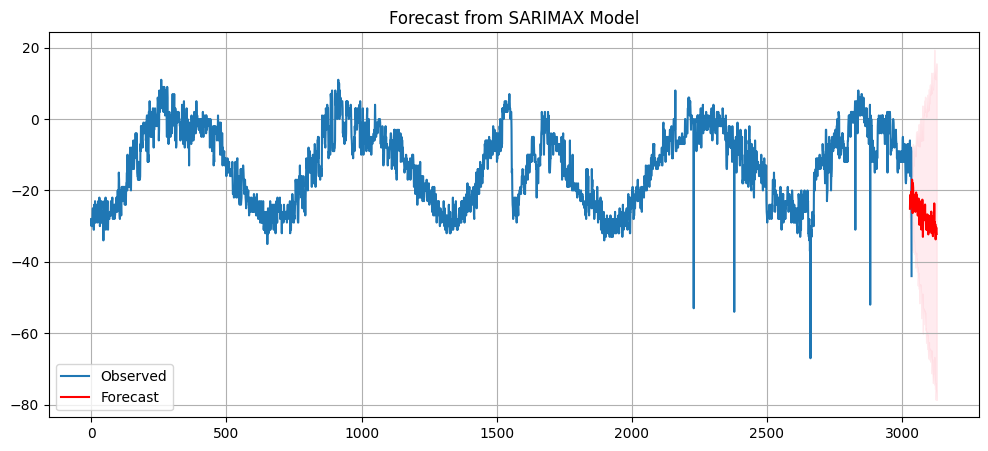

In [55]:
ax = df['max_temp'].plot(label='Observed', figsize=(12, 5))

# Plot forecast
forecast_values.plot(ax=ax, label='Forecast', color='red')

# Plot confidence intervals
ax.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1],
                color='pink', alpha=0.3)

plt.title("Forecast from SARIMAX Model")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
train = df['max_temp'][:-700]  # all but last n values
test = df['max_temp'][-700:]   # last n values

In [57]:
forecast = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [58]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²   : {r2:.3f}")

MAE: 0.95
RMSE: 1.51
MAPE: 9974265947378008.00%
R²   : 0.978


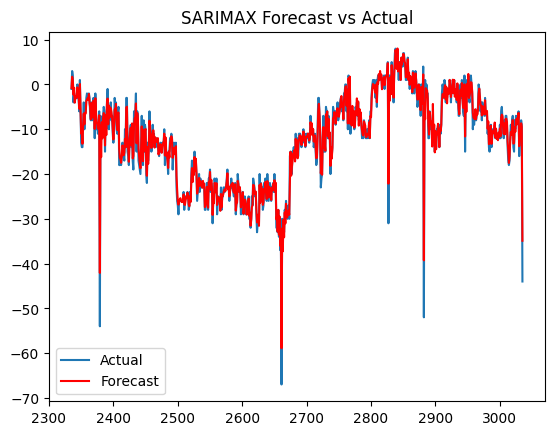

In [59]:
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()

### Pressure

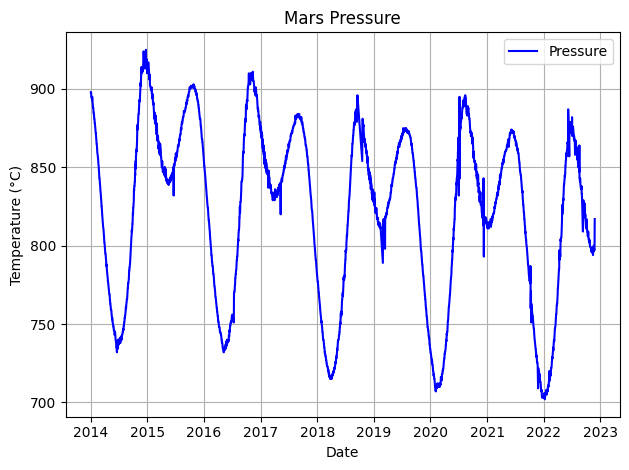

In [60]:
plt.plot(df['terrestrial_date'], df['pressure'], label='Pressure', color='blue')
plt.title('Mars Pressure')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

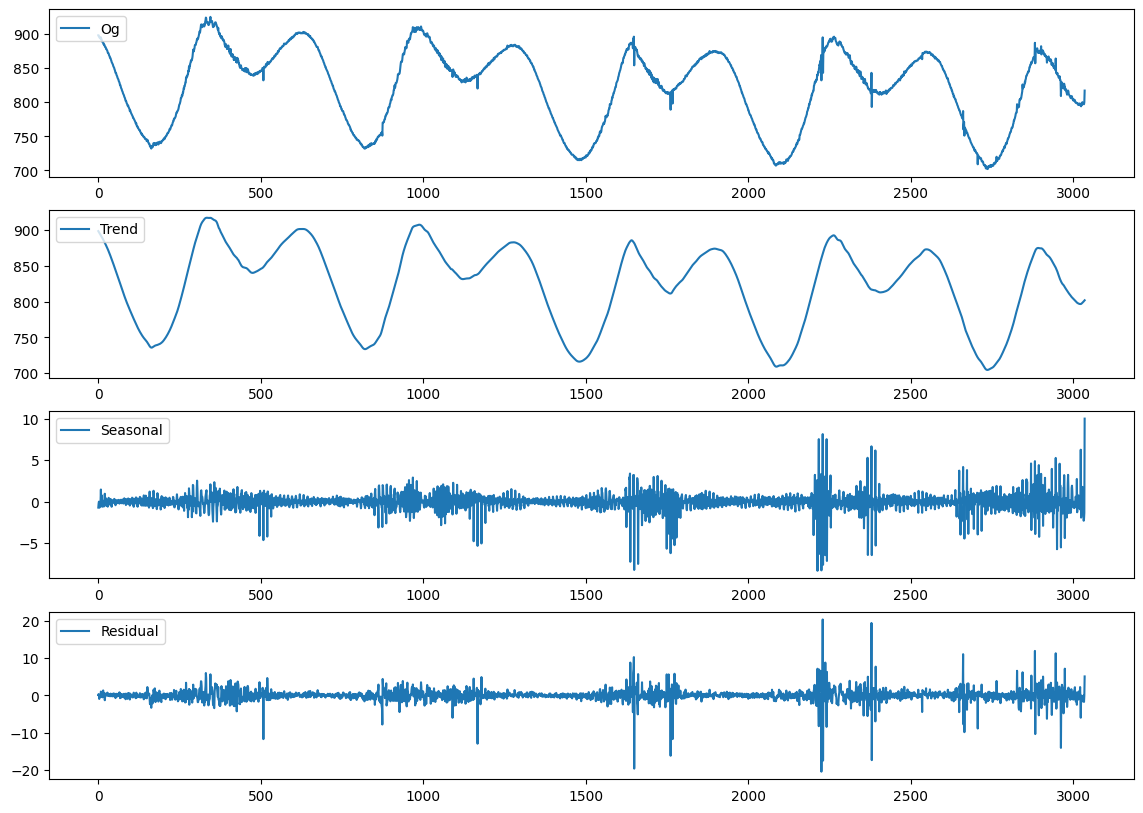

In [61]:
stl = STL(df['pressure'], period=12)  # e.g., 12 for monthly data
result=stl.fit()
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(result.observed,label='Og')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend,label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid,label='Residual')
plt.legend(loc='upper left')

In [62]:
result = adfuller(df['pressure'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  #d=0

ADF Statistic: -9.659232664455908
p-value: 1.3676512642382845e-16


In [63]:
print(adfuller(df['pressure'].diff().dropna())) #D=1

(np.float64(-3.2026218345020743), np.float64(0.01983341785062203), 28, 2999, {'1%': np.float64(-3.43253236279788), '5%': np.float64(-2.86250422682754), '10%': np.float64(-2.5672832833096195)}, np.float64(14180.271058895694))


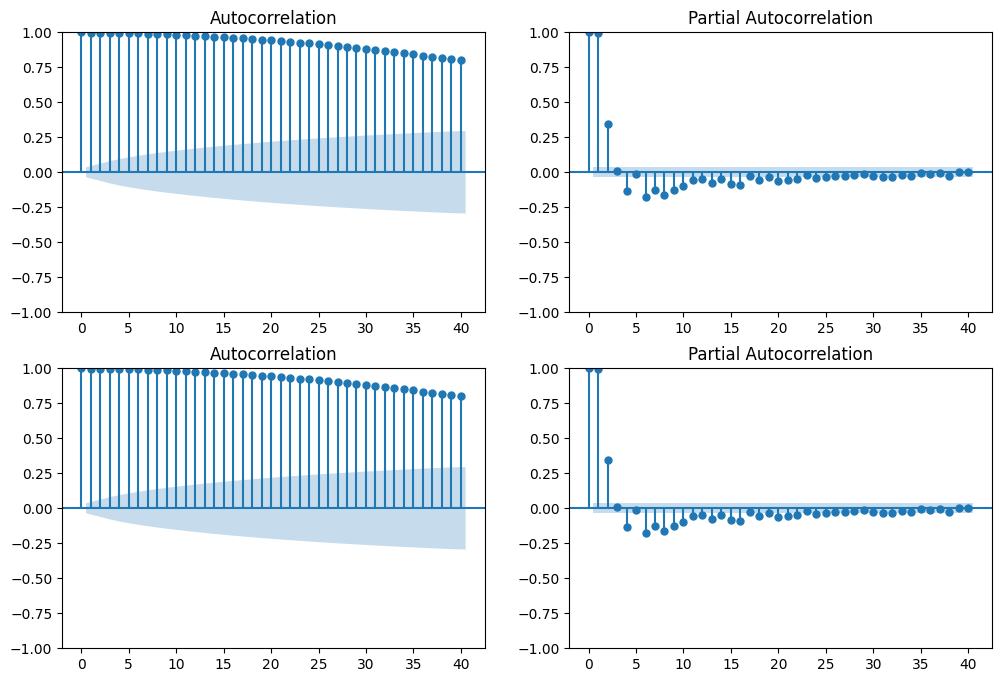

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
# Non-seasonal ACF and PACF
plot_acf(df['pressure'].dropna(), lags=40, ax=axes[0,0])
plot_pacf(df['pressure'].dropna(), lags=40, ax=axes[0,1])
# Seasonal ACF and PACF (lags at multiples of s)
plot_acf(df['pressure'].dropna(), lags=40, ax=axes[1,0])
plot_pacf(df['pressure'].dropna(), lags=40, ax=axes[1,1])

plt.show()

In [65]:
model = SARIMAX(df['pressure'], order=(1,1,0), seasonal_order=(1,1,1,12))
results = model.fit()

print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             pressure   No. Observations:                 3029
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -7566.573
Date:                              Sun, 15 Jun 2025   AIC                          15141.146
Time:                                      19:52:38   BIC                          15165.192
Sample:                                           0   HQIC                         15149.793
                                             - 3029                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4491      0.005    -92.462      0.000      -0.459      -0.440
ar.S.L12       0.20

In [66]:
train = df['pressure'][:-700]  # all but last n values
test = df['pressure'][-700:]   # last n values

In [67]:
forecast = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [69]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²   : {r2:.3f}")

MAE: 1.92
RMSE: 3.60
MAPE: 0.24%
R²   : 0.995


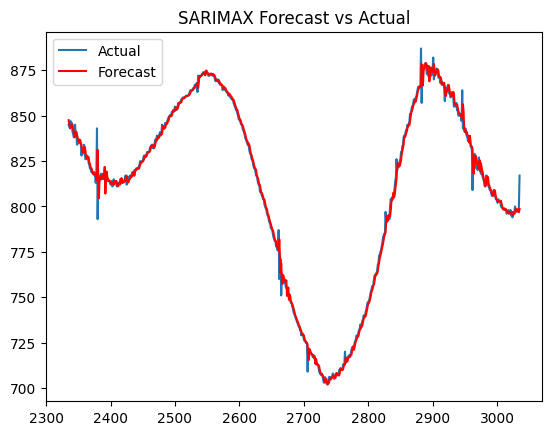

In [68]:
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()